# Technical Summary


## Problem
1. **WHEN & WHERE & (WHO)** to reduce severity & frequency of damaging collisions

## Scope
1. Geo: NYC
2. Events: Collisions with damage cost
3. Timespan: post 2017 with an emphasis on post-covid period



## Definitions for target variables

**How to define damage?**
- Damage defined in a way that the audience care the most
1. Damage: injured or killed involved
2. Severity: No. of injured + No. of killed * 10
2. Frequency: No. of damaging collision

## Data quality & relevance

### Collision data 

1. Data distribution & sampling has a disparity before and after mid **2016**. With the info that data prototype changed during 2016, we only take **post-2017** data for analysis.
2. We detect no extreme outliers in target variables (No. of collisions, the injured & killed) over time
3. Target variables have different patterns before and after **2020** due to Covid lockdowns
4. Target variables see high volatility around Apr 2020 due to Covid lockdowns

----> **Actions: Transform target variable into percent change for further anlaysis as it is non-stationary specially around Covid peak**


5. Missing locaton (Latitude & longitude) info is distributed randomly over time with an occasionally spiked number, albeit an overall smaller level **pre-2019** 
6. Zipcode & borough info is missing in a overall random pattern albeit a lasting mean deviation **mid 2017**
7. Missing street name info happens mostly **pre-2019**

----> **Actions: Take post-2017 data only. It is adequate for further analysis**

8. We believe that collisions data provided is geographically limited to NYC with an estimated **<1%** violation, based on the following 3 assumptions:
     
    1. zipcode, lat/lng & street, when available, is reliable info
    2. errors of the mapping from street info to zipcode or lat/lng are random
    3. errors of the mapping from lat/lng to zipcode are random
    

    Detailed analysis as follows: 
    
        1) when zipcode is available (70%), 0.06% (0.04% of the whole data) are out of nyc
        2) when zipcode is missing but lat/lng & street info is available(30%), 0.007% (0.002% of the whole data) is confirmed out of nyc.
        3) when zipcode and lat/lng is missing (5.4%), we can impute 98% of the data using street info. And 2% (0.09% of the whole data) is inferred as out of nyc 
        4) when zipcode, lat/lng and street is all missing, we cannot infer location any more. It takes 0.06% data. They are not randomly distributed. Most of missing data happens pre-2019. 
        5) we estimate that lat/lng infers the same zip codes as provided 80% of the time. Street info infers the same zip code as lat/lng 40% of the time. 
        
----> **Actions: Take out collisions (0.06%) which have no location info at all**

**----> Conclusion: Collision data is relevant to the Prompt in terms that 99%+ records are NYC located. However, if more granularity with precision is needed, imputing zip code data from lat/long or street info (especially from street) needs careful thoughts**


### Weather data 
1. 2 out of 3 station readings are relevant to NYC
2. Two station readings are quite correlated across 5 core features with biggest difference in PRCP

**---> Action: Take daily mean of two station readings for 5 core features based on the assumption of equal weights of their impact on collisions** 

3. WT features are quite sparse.

**---> Action: Merge WT01 & WT02, and create a new feature WT by combining the rest**

4. Missing value detected in AWND from one reading

**---> Action: Drop that reading based on the observation that two readings are highly correlated and the assumption that one reading is adequate enough to represent NYC wind speed for modelling collisions.**



## Weather impact on collisions

1. **Model**: linear regression
2. **Features**: 
      
       'PRCP' (daily diff), 'TMAX' (daily diff), 'TMIN'(daily diff), 'AWND'(daily diff),'SNOW'(daily diff) ,'SNWD'(daily diff), 'WT01', 'WT*'
       
3. **Target**: Frequency (number of collisions, daily pct chng), Severity (collision eco_cost, daily pct chng)
4. **Timespan**: 20170101 - 20221231
5. **Results**:

    a. Frequency
![Alt Text](frequency.png)

    b. Severity
![Alt Text](severity.png)

6. **Discussion & Interpretations**

    * After validating the assumptions of linear regression, we conclude that within the timespan examined, by controllding other factors, **temperature** (in max diurnal temperature range) and **snowy days** (in snowfall) have shown statistically significant impact on both the frequency of collisions and their severity.
    
         *Detailedly, with other factors unchanged, ten unit change in the daily change of max diurnal temperature  will lead to 4% - 7% change in the daily pct change in collision frequency. In other words, higher max temperature and can drive the increase of collisions. This applies to severity in a similar way.*
         
         *Snowfall however impact collisions in an opposite way. Heavier snowy days are likely to see fewer damaging collisions and less severe ones.*
        
    * Other factors such as precipitation and wind speed haven't shown significant linear impact over the entire timespan examined.
    
    * Intuition: Human factors are often the primary contributors to traffic collisions. And temperature can impact people's mood and behavior. Temperature can also impact cognitive performance. Extreme temperatures, whether too hot or too cold, can hinder concentration, decision-making, and overall cognitive function.
 

    
7. **Limitations & Next steps**

    1. Apply non-linear / Non-parametric models to capture extreme weather impact
    2. More detailed error analysis needed
    3. More feature engineering
    4. Boostrap samples / timestamps for a more robust model
    5. Better missing data strategy
    6. Model on greater geography granularity



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import dask.dataframe as dd
from geopy.geocoders import Nominatim

import statsmodels.api as sm
import re
from scipy import stats

In [2]:
collision_df = pd.read_csv('analyst_assessment/CollisionsData.csv')
weather_df = pd.read_csv('analyst_assessment/WeatherData.csv')

collision_df['CRASH DATE'] = list(map(lambda x:pd.to_datetime(x,format = '%m/%d/%Y'),collision_df['CRASH DATE']))

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_31298/2059095032.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collision_df = pd.read_csv('analyst_assessment/CollisionsData.csv')


In [3]:
collision_df['ECO_COST'] = collision_df['NUMBER OF PERSONS INJURED']+collision_df['NUMBER OF PERSONS KILLED']*10
collision_df['ON STREET NAME'] = collision_df['ON STREET NAME'].fillna(collision_df['CROSS STREET NAME']).fillna(collision_df['OFF STREET NAME'])


def clean_string(input_string):
    if pd.isnull(input_string):
        return input_string
    cleaned_string = input_string.strip()
    cleaned_string = re.sub(r'\s+', ' ', cleaned_string)
    return cleaned_string

collision_df['ON STREET NAME'] = collision_df['ON STREET NAME'].apply(clean_string)

In [4]:
collision_df.isnull().sum()/collision_df.shape[0]

CRASH DATE                       0.000000
CRASH TIME                       0.000000
BOROUGH                          0.311001
ZIP CODE                         0.311120
LATITUDE                         0.114321
LONGITUDE                        0.114321
LOCATION                         0.114321
ON STREET NAME                   0.046313
CROSS STREET NAME                0.372098
OFF STREET NAME                  0.837115
NUMBER OF PERSONS INJURED        0.000009
NUMBER OF PERSONS KILLED         0.000016
NUMBER OF PEDESTRIANS INJURED    0.000000
NUMBER OF PEDESTRIANS KILLED     0.000000
NUMBER OF CYCLIST INJURED        0.000000
NUMBER OF CYCLIST KILLED         0.000000
NUMBER OF MOTORIST INJURED       0.000000
NUMBER OF MOTORIST KILLED        0.000000
CONTRIBUTING FACTOR VEHICLE 1    0.003109
CONTRIBUTING FACTOR VEHICLE 2    0.151597
CONTRIBUTING FACTOR VEHICLE 3    0.929435
CONTRIBUTING FACTOR VEHICLE 4    0.984210
CONTRIBUTING FACTOR VEHICLE 5    0.995742
COLLISION_ID                     0

In [5]:
collision_df.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                                  object
ZIP CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
LOCATION                                 object
ON STREET NAME                           object
CROSS STREET NAME                        object
OFF STREET NAME                          object
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
CONTRIBUTING FACTOR VEHICLE 3           

In [6]:
collision_df['ZIP CODE'] = collision_df['ZIP CODE'].replace('     ', np.nan).astype(float)

In [7]:
# day of week
# month
from datetime import datetime

def extract_day_of_week(date_object):
    try:
        day_of_week = date_object.weekday()
        return day_of_week
    except ValueError:
        return "Invalid date format"
def extract_month(date_object):
    try:
        month = date_object.month
        return month
    except ValueError:
        return "Invalid date format"
    
collision_df['month'] = collision_df['CRASH DATE'].apply(extract_month)
collision_df['day_of_week'] = collision_df['CRASH DATE'].apply(extract_day_of_week)


def convert_to_datetime_and_round_hour(time_string):
    try:
        time_object = datetime.strptime(time_string, "%H:%M")
        if time_object.minute >= 30:
            hour = time_object.hour + 1
        else:
            hour = time_object.hour
        return hour
    except ValueError:
        return "Invalid time format"

collision_df['CRASH TIME'] = collision_df['CRASH TIME'].apply(convert_to_datetime_and_round_hour)

<Axes: >

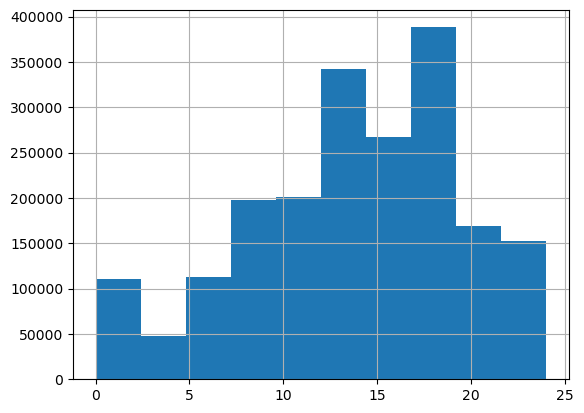

In [8]:
collision_df['CRASH TIME'].hist()

# Perspective 1: Target

## Value validation

In [9]:
print(sum(collision_df['NUMBER OF PERSONS INJURED'] != (collision_df['NUMBER OF PEDESTRIANS INJURED'] + \
collision_df['NUMBER OF CYCLIST INJURED'] + collision_df['NUMBER OF MOTORIST INJURED'])))

collision_df['NUMBER OF PERSONS INJURED'] = (collision_df['NUMBER OF PEDESTRIANS INJURED'] + \
collision_df['NUMBER OF CYCLIST INJURED'] + collision_df['NUMBER OF MOTORIST INJURED'])

print(
sum(collision_df['NUMBER OF PERSONS KILLED'] != (collision_df['NUMBER OF PEDESTRIANS KILLED'] + \
collision_df['NUMBER OF CYCLIST KILLED'] + collision_df['NUMBER OF MOTORIST KILLED'])))

collision_df['NUMBER OF PERSONS KILLED'] = (collision_df['NUMBER OF PEDESTRIANS KILLED'] + \
collision_df['NUMBER OF CYCLIST KILLED'] + collision_df['NUMBER OF MOTORIST KILLED'])

5589
80


In [10]:
collision_df['LATITUDE'] = collision_df['LATITUDE'].replace(0,np.nan)
collision_df['LONGITUDE'] = collision_df['LONGITUDE'].replace(0,np.nan)


collision_df.loc[collision_df['LATITUDE'] > 41, 'LATITUDE'] = np.nan
collision_df.loc[collision_df['LONGITUDE'] < -74.6, 'LONGITUDE'] = np.nan
collision_df.loc[collision_df['LONGITUDE'] > -50, 'LONGITUDE'] = np.nan

### over 75% collisions don't have human capital cost 

In [11]:
print(collision_df['NUMBER OF PERSONS INJURED'].describe())
print(collision_df['NUMBER OF PERSONS KILLED'].describe())
print(collision_df['ECO_COST'].describe())

count    1.987996e+06
mean     2.955207e-01
std      6.883157e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.300000e+01
Name: NUMBER OF PERSONS INJURED, dtype: float64
count    1.987996e+06
mean     1.406944e-03
std      3.953370e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.000000e+00
Name: NUMBER OF PERSONS KILLED, dtype: float64
count    1.987959e+06
mean     3.124773e-01
std      8.012549e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.200000e+01
Name: ECO_COST, dtype: float64


In [12]:
collision_df = collision_df[collision_df['ECO_COST']>0]

#  Perspective 1: When

### Data behaves quite differently before and after 2016 

- Data prototype changed around 2016

Therefore, the Department in March 2016 replaced the TAMS with the new Finest Online Records Management System (FORMS).  FORMS enables the police officers to electronically, using a Department cellphone or computer, enter all of the MV-104AN data fields and stores all of the MV-104AN data fields in the Department’s crime data warehouse.  Since all of the MV-104AN data fields are now stored for each traffic collision, detailed traffic safety analyses can be conducted as applicable. 


<Axes: title={'center': 'Daily location info missing ratio over time'}, xlabel='CRASH DATE'>

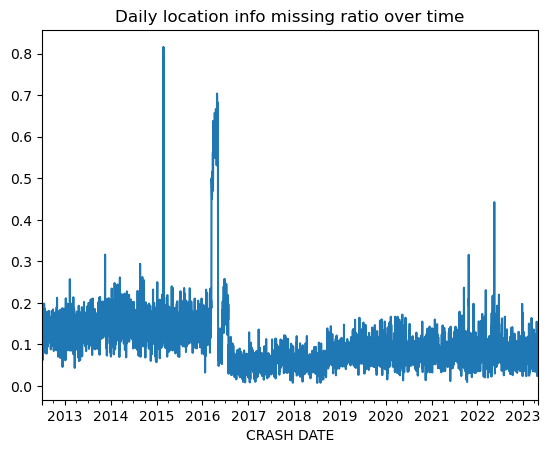

In [15]:
(collision_df[collision_df['LOCATION'].isnull()].sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']).plot(title = "Daily location info missing ratio over time")

<Axes: title={'center': 'Daily zipcode info missing ratio over time'}, xlabel='CRASH DATE'>

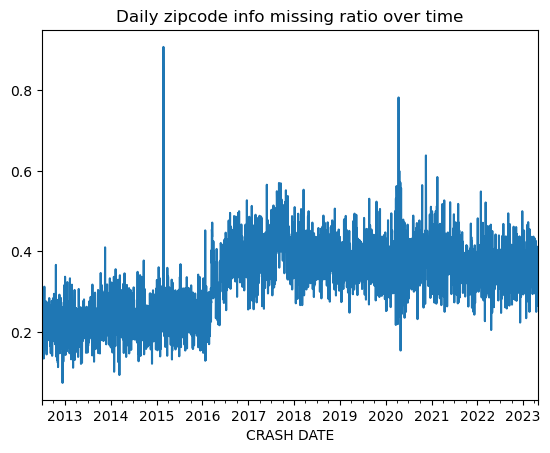

In [16]:
(collision_df[collision_df['ZIP CODE'].isnull()].sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']).plot(title = "Daily zipcode info missing ratio over time")

### fitler timespan and take 2017 and forwards only

In [17]:
collision_df = collision_df[collision_df['CRASH DATE']>='2017-01-01']
collision_df.shape

(258734, 32)

<Axes: title={'center': 'Daily location info missing ratio over time'}, xlabel='CRASH DATE'>

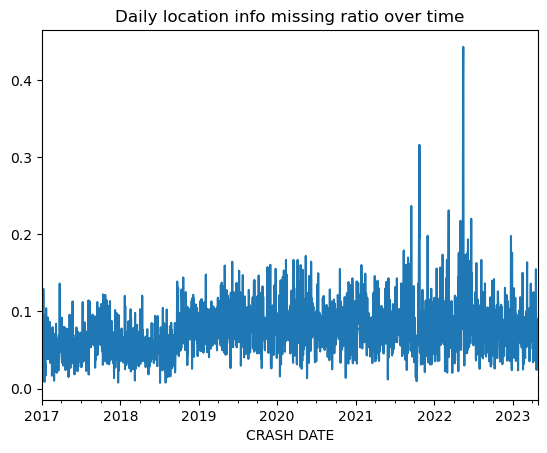

In [18]:
(collision_df[collision_df['LOCATION'].isnull()].sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']).plot(title = "Daily location info missing ratio over time")

<Axes: title={'center': 'Daily zipcode info missing ratio over time'}, xlabel='CRASH DATE'>

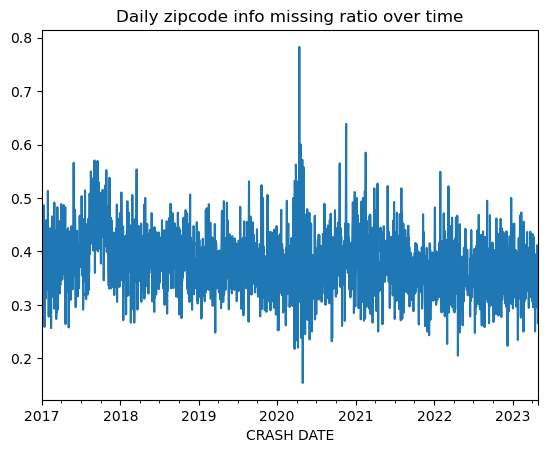

In [19]:
(collision_df[collision_df['ZIP CODE'].isnull()].sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']).plot(title = "Daily zipcode info missing ratio over time")

<Axes: title={'center': 'Daily borough info missing ratio over time'}, xlabel='CRASH DATE'>

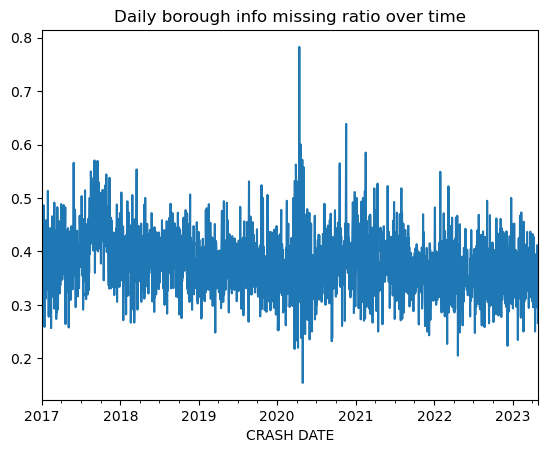

In [21]:
(collision_df[collision_df['BOROUGH'].isnull()].sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']).plot(title = "Daily borough info missing ratio over time")

<Axes: title={'center': 'Daily street info missing ratio over time'}, xlabel='CRASH DATE'>

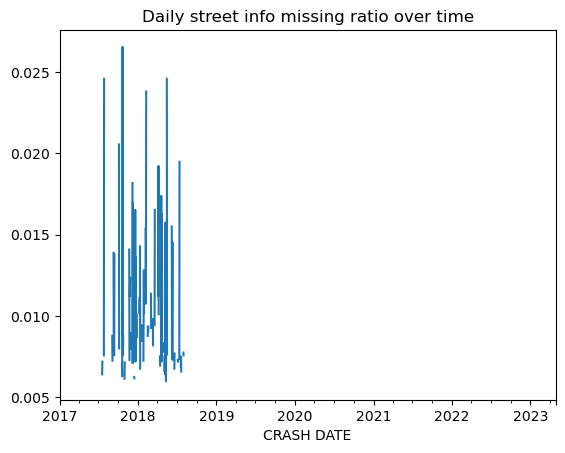

In [22]:
(collision_df[collision_df['ON STREET NAME'].isnull()].sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.sort_values('CRASH DATE').groupby('CRASH DATE').count(
)['CRASH TIME']).plot(title = "Daily street info missing ratio over time")

### Eco behavior perform differently before and after 2020 (covid) ---> non-stationary series

<Axes: xlabel='CRASH DATE'>

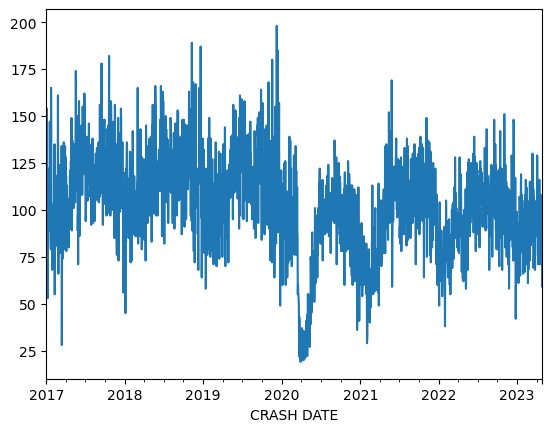

In [23]:
collision_df.groupby('CRASH DATE')['LOCATION'].nunique().plot()

### THEREFORE, we take pct change as our target

----> will tomorrow collisions increase dramatically?

<Axes: xlabel='CRASH DATE'>

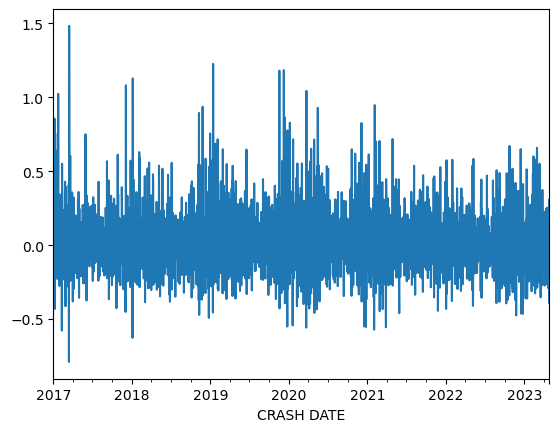

In [24]:
collision_df.groupby('CRASH DATE').count()['CRASH TIME'].pct_change().plot()

### and its distribution ---> small std and with a little longer right tail ----> no outlier detected

<Axes: >

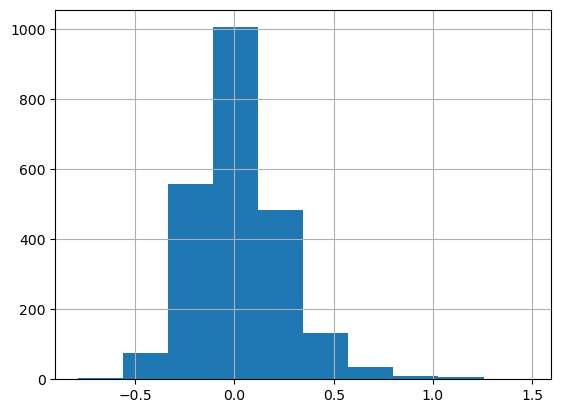

In [25]:
collision_df.groupby('CRASH DATE').count()['CRASH TIME'].pct_change().hist()

### not stationary

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_26543/406033405.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  collision_df.groupby('CRASH DATE').sum()['ECO_COST'].plot()


<Axes: xlabel='CRASH DATE'>

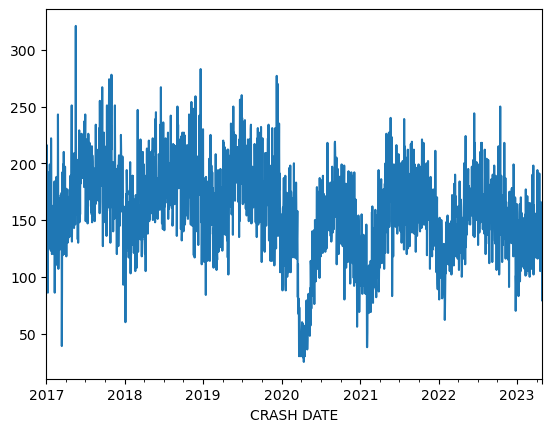

In [26]:
collision_df.groupby('CRASH DATE').sum()['ECO_COST'].plot()

### THEREFORE, we take daily pct change again

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_26543/534172354.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  collision_df.groupby('CRASH DATE').sum()['ECO_COST'].pct_change().plot()


<Axes: xlabel='CRASH DATE'>

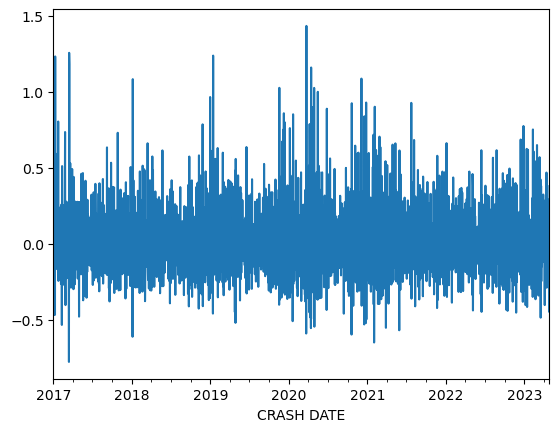

In [27]:
collision_df.groupby('CRASH DATE').sum()['ECO_COST'].pct_change().plot()

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_26543/1571090792.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  collision_df.groupby('CRASH DATE').sum()['ECO_COST'].pct_change().hist()


<Axes: >

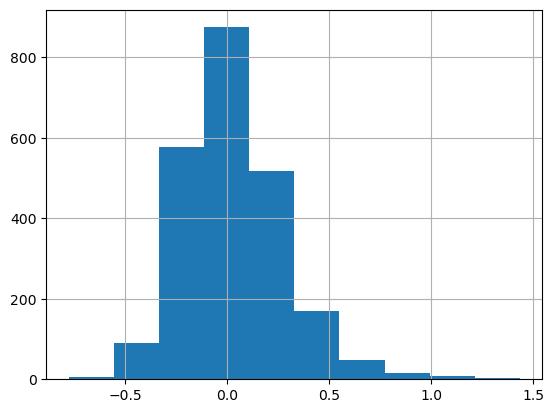

In [28]:
collision_df.groupby('CRASH DATE').sum()['ECO_COST'].pct_change().hist()

# Perspective 2: Where

1. Impute missing data to get location info as many as possible
2. cross-validate location data using zip code, lat/lng & street

## Zip Code

In [29]:
nyc_borough_zipcode = {"Manhattan":list(range(10001, 10283)),
"Staten Island" :list(range(10301, 10315)),
"Bronx": list(range(10451, 10476)),
"Queens":list(range(11004, 11110))+ list(range(11351, 11698)),
"Brooklyn":list(range(11201, 11257))}

nyc_zipcodes = list(nyc_borough_zipcode.values())
from itertools import chain
nyc_zipcodes = list(chain.from_iterable(nyc_zipcodes))

In [30]:
collision_df[collision_df['ZIP CODE'].isin(
    [i for i in collision_df['ZIP CODE'].dropna().unique() if i not in nyc_zipcodes])].shape[0]/collision_df.shape[0]

0.0005836109672482163

In [31]:
list_tmp = []
for i in collision_df['ZIP CODE']:
    if pd.isnull(i):
        list_tmp.append(np.nan)
    elif i not in nyc_zipcodes:
        list_tmp.append(True)
    else:
        list_tmp.append(False)
collision_df['zip_code_filter'] = list_tmp

In [32]:
collision_df.groupby('zip_code_filter').count()['CRASH DATE']/collision_df.groupby('zip_code_filter').count()['CRASH DATE'].sum()

zip_code_filter
False    0.99906
True     0.00094
Name: CRASH DATE, dtype: float64

In [33]:
collision_df.to_csv('zip_code_filter.csv')

## When zip code is missing, use Lat & Long

In [34]:
collision_df_sub = collision_df[(collision_df['ZIP CODE'].isnull()) & ~(collision_df['LATITUDE'].isnull())]
collision_df_sub.shape

(82557, 33)

In [40]:
collision_df_sub.shape[0]/collision_df.shape[0]

0.31908060015305295

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

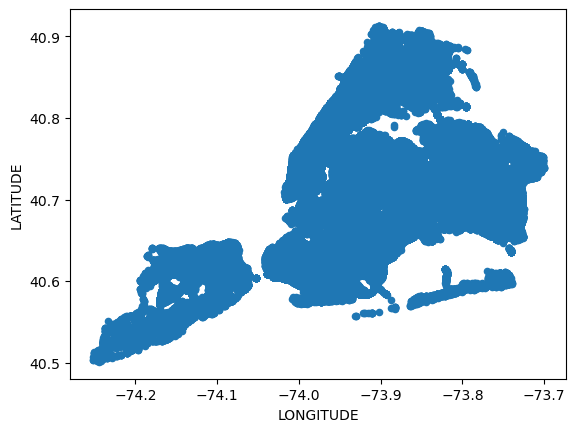

In [35]:
collision_df.plot.scatter(y='LATITUDE',x = 'LONGITUDE')

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

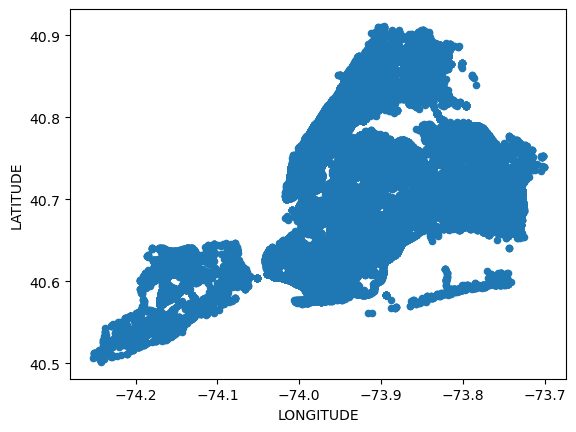

In [36]:
collision_df_sub.plot.scatter(y='LATITUDE',x = 'LONGITUDE')

In [37]:
# Load the New York City boundary shapefile or GeoJSON
nyc = gpd.read_file("Borough Boundaries/geo_export_f5019a7b-0c9f-4f9d-8b83-a9117ea27b2d.shp").to_crs("EPSG:4326")
## this shpfile is not entire nyc
geolocator = Nominatim(user_agent="miya")    

def geo_filter(row):
    long = row['LONGITUDE']
    lat = row['LATITUDE']
    if not pd.isnull(long):
        for index, row in nyc.iterrows():
            if row['geometry'].contains(Point(long, lat)):
                return True
        return False
                
    else:
        return np.nan
    
num_partitions = 8
dask_df = dd.from_pandas(collision_df_sub, npartitions=num_partitions)
dask_df['latlng_filter'] = dask_df.apply(geo_filter, axis=1, meta=('new_column', 'str'))
computed_result = dask_df.compute()
print(sum(computed_result['latlng_filter']==False)/computed_result.dropna(subset=['latlng_filter']).shape[0])
collision_df_sub = computed_result

0.015857248422149268


In [38]:
collision_df_sub2 = collision_df_sub[collision_df_sub['latlng_filter']==False]
collision_df_sub2.shape

(1309, 34)

In [39]:
## further validate
geolocator = Nominatim(user_agent="osso")    
def geo_filter_2(row):
    long = row['LONGITUDE']
    lat = row['LATITUDE']
    loc = str(lat)+', '+str(long)
    geo = geolocator.reverse(loc,timeout=100,addressdetails=True)
    if geo:
        zipcode = int(geo.raw.get('address', {}).get('postcode'))
        return zipcode not in nyc_zipcodes
        
    return np.nan
    
num_partitions = 8
dask_df = dd.from_pandas(collision_df_sub2, npartitions=num_partitions)
dask_df['latlng_filter2'] = dask_df.apply(geo_filter_2, axis=1, meta=('new_column', 'str'))
computed_result = dask_df.compute()
print(sum(computed_result['latlng_filter2'])/computed_result.dropna(subset=['latlng_filter2']).shape[0])
collision_df_sub2 = computed_result

0.0053475935828877


In [42]:
collision_df_sub2[collision_df_sub2['latlng_filter2']]['ON STREET NAME'].unique()

array(['245 STREET', 'CROSS ISLAND PARKWAY', 'JAMAICA AVENUE'],
      dtype=object)

In [43]:
collision_df_sub2[collision_df_sub2['latlng_filter2']].shape[0]/collision_df.shape[0]

2.7054813051241817e-05

In [44]:
collision_df_sub2[collision_df_sub2['latlng_filter2']].to_csv("zipcodemissing_latlng.csv")

## When zip code, Lat & Long are missing,  use street info

In [45]:
collision_df_sub3 = collision_df[(collision_df['ZIP CODE'].isnull()) \
                                 & (collision_df['LATITUDE'].isnull()) \
                                 & ~(collision_df['ON STREET NAME'].isnull())]
print(collision_df_sub3.shape)
print(collision_df_sub3.shape[0]/collision_df.shape[0])

(15349, 33)
0.05932347507478723


In [48]:
collision_df_sub3.drop_duplicates('ON STREET NAME').shape

(2180, 33)

In [52]:
collision_df_sub2_sample = collision_df_sub3.drop_duplicates('ON STREET NAME')

geolocator = Nominatim(user_agent="miya")    
def create_location_filter(row):
    location = row['ON STREET NAME']
    geo = geolocator.geocode(location + ', NYC',timeout=100,addressdetails=True)
    if geo:
        zipcode = geo.raw.get('address', {}).get('postcode')
        if zipcode:
            return int(zipcode) not in nyc_zipcodes  
        else:
            print(location)
            return True
    return np.nan

num_partitions = 8
dask_df = dd.from_pandas(collision_df_sub2_sample, npartitions=num_partitions)
dask_df['street_filter'] = dask_df.apply(create_location_filter, axis=1, meta=('new_column', 'str'))
computed_result2 = dask_df.compute()
print((computed_result2['street_filter']!=np.nan).sum()/computed_result2.shape[0])

RIVERSIDE PARK
FORT TRYON PARK
EAST RIVER PARK
Avenue of Science
Riverside Park
HUTCHINSON RIVER PARKWAY
Hutchinson river parkway
MARTIN LUTHER KING JR
ALBEE SQUARE
COOPER SQUARE
PELHAM BAY PARK
ORCHARD BEACH
HIGHLAND PARK
WATERSIDE PLAZA
GRAND ARMY PLAZA
MILLER FIELD
MEADOW LAKE
Westchester Square
EAST RIVER
WESTCHESTER SQUARE
CROTONA PARK
34
2065
PENNSYLVANIA
454
1.0


In [64]:
violated_street = ['HUTCHINSON RIVER PARKWAY','Hutchinson river parkway','PENNSYLVANIA','34','2065',
                  '454']
street_filter = collision_df_sub3[collision_df_sub3['ON STREET NAME'].isin(violated_street)]

In [65]:
street_filter.to_csv('street_filter.csv')

In [78]:
print(street_filter.shape[0]/collision_df.shape[0])
print(street_filter.shape[0]/collision_df_sub3.shape[0])

0.0008928088306909799
0.015049840380480814


### when zip code, Lat & Long, street are all mising, we cannot validate. It consists 0.06% data

The question is should we ignore them and keep them in the samples?

Action:

Take them out as they don't distribution across time randomly and at its most, it can construct 4% collisions for a day.

In [66]:
collision_df[(collision_df['ZIP CODE'].isnull()) \
                                 & (collision_df['LATITUDE'].isnull()) \
                                 & (collision_df['ON STREET NAME'].isnull())].shape[0]/collision_df.shape[0]

0.0004715267417502145

<Axes: xlabel='CRASH DATE'>

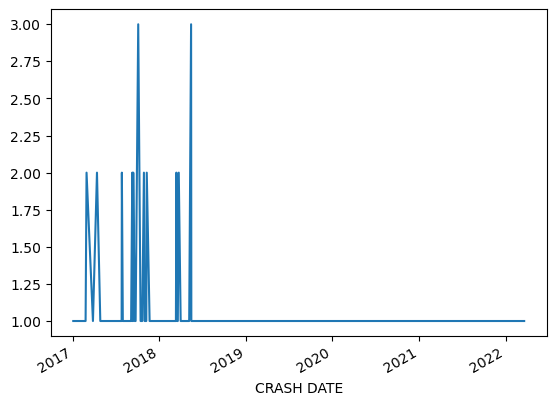

In [67]:
collision_df[(collision_df['ZIP CODE'].isnull()) \
                                 & (collision_df['LATITUDE'].isnull()) \
                                 & (collision_df['ON STREET NAME'].isnull())].groupby('CRASH DATE').count(
)['CRASH TIME'].plot()

<Axes: xlabel='CRASH DATE'>

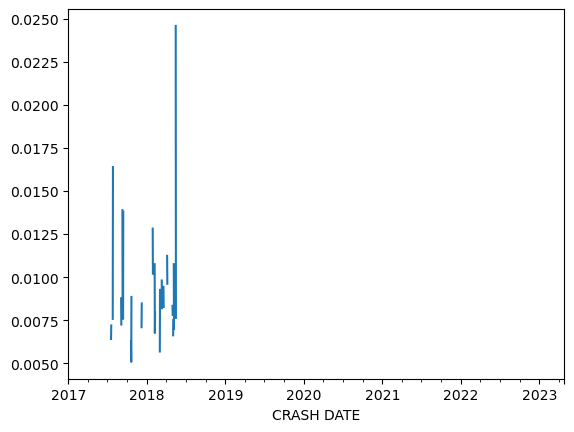

In [68]:
(collision_df[(collision_df['ZIP CODE'].isnull()) \
                                 & (collision_df['LATITUDE'].isnull()) \
                                 & (collision_df['ON STREET NAME'].isnull())].groupby('CRASH DATE').count(
)['CRASH TIME']/collision_df.groupby('CRASH DATE').count(
)['CRASH TIME']).plot()

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_26543/3357242949.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  & (collision_df['ON STREET NAME'].isnull())].groupby('CRASH DATE').sum(


<Axes: xlabel='CRASH DATE'>

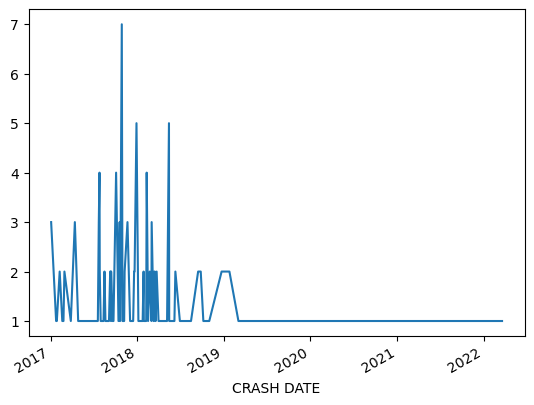

In [69]:
collision_df[(collision_df['ZIP CODE'].isnull()) \
                                 & (collision_df['LATITUDE'].isnull()) \
                                 & (collision_df['ON STREET NAME'].isnull())].groupby('CRASH DATE').sum(
)['ECO_COST'].plot()

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_26543/506466689.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  & (collision_df['ON STREET NAME'].isnull())].groupby('CRASH DATE').sum(
/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_26543/506466689.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  )['ECO_COST']/collision_df.groupby('CRASH DATE').sum(


<Axes: xlabel='CRASH DATE'>

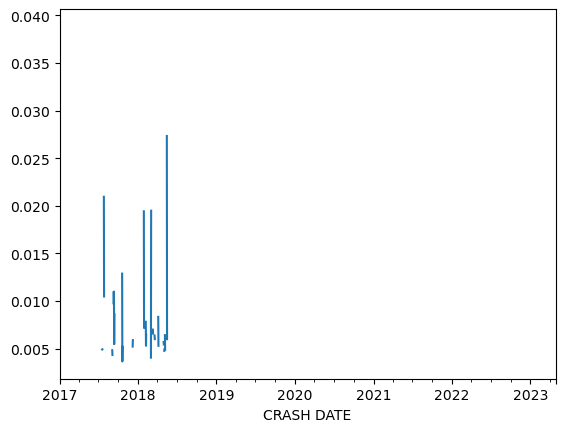

In [70]:
(collision_df[(collision_df['ZIP CODE'].isnull()) \
                                 & (collision_df['LATITUDE'].isnull()) \
                                 & (collision_df['ON STREET NAME'].isnull())].groupby('CRASH DATE').sum(
)['ECO_COST']/collision_df.groupby('CRASH DATE').sum(
)['ECO_COST']).plot()

### cross validate zip code, lat & long , street by sampling

In [71]:
collision_df_sub4 = collision_df[~(collision_df['ZIP CODE'].isnull()) \
                                 & ~(collision_df['LATITUDE'].isnull()) \
                                 & ~(collision_df['ON STREET NAME'].isnull())]
print(collision_df_sub4.shape)
print(collision_df_sub4.shape[0]/collision_df.shape[0])

(155466, 33)
0.6008719379749086


In [72]:
def geo_validate(row):
    long = row['LONGITUDE']
    lat = row['LATITUDE']
    street = row['ON STREET NAME']
    
    loc = str(lat)+', '+str(long)
    geo = geolocator.reverse(loc,timeout=100,addressdetails=True)
    zipcode_street = np.nan
    zipcode_latlong = np.nan
    if geo:
        zipcode_latlong = int(geo.raw.get('address', {}).get('postcode'))
    geo = geolocator.geocode(street + ', NYC',timeout=100,addressdetails=True)
    if geo:
        zipcode_street = int(geo.raw.get('address', {}).get('postcode'))
    return zipcode_latlong, zipcode_street

list_res = []
num_partitions = 8
for i in list(range(10)): #sample 10 batches
    dask_df = dd.from_pandas(collision_df_sub4.sample(n=100,random_state=i), npartitions=num_partitions)
    dask_df['zipcode_generated'] = dask_df.apply(geo_validate, axis=1, meta=('new_column', 'str'))
    computed_result = dask_df.compute()
    list_res.append(computed_result)
    print(i)

0
1
2
3
4
5
6
7
8
9


In [73]:
collision_df_impute_zipcode = pd.concat(list_res)

In [74]:
collision_df_impute_zipcode['zipcode_latlong'] = collision_df_impute_zipcode['zipcode_generated'].apply(lambda x:x[0])
collision_df_impute_zipcode['zipcode_street'] = collision_df_impute_zipcode['zipcode_generated'].apply(lambda x:x[1])

In [75]:
tmp = collision_df_impute_zipcode[['zipcode_latlong','ZIP CODE']].dropna()
print(sum(tmp['ZIP CODE']==tmp['zipcode_latlong'])/tmp.shape[0])

tmp = collision_df_impute_zipcode[['zipcode_latlong','zipcode_street']].dropna()
print(sum(tmp['zipcode_street']==tmp['zipcode_latlong'])/tmp.shape[0])

tmp = collision_df_impute_zipcode[['ZIP CODE','zipcode_street']].dropna()
print(sum(tmp['zipcode_street']==tmp['ZIP CODE'])/tmp.shape[0])

0.834
0.3762993762993763
0.37525987525987525


In [76]:
collision_df_impute_zipcode[['ZIP CODE','zipcode_latlong']].diff(axis=1).describe()

,ZIP CODE,zipcode_latlong
count,0.0,1000.000000
mean,NaN,-0.211000
std,NaN,25.084172
min,NaN,-425.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000
max,NaN,273.000000


## Exclude out-of-nyc collisions

In [88]:
print(collision_df.shape)
collision_df_filtered = collision_df[collision_df['zip_code_filter']!=True]

collision_df_filtered = collision_df_filtered[~collision_df_filtered['COLLISION_ID'].isin(
    collision_df_sub2[collision_df_sub2['latlng_filter2']]['COLLISION_ID']
)]

collision_df_filtered = collision_df_filtered[~collision_df_filtered['COLLISION_ID'].isin(
    street_filter['COLLISION_ID']
)]

collision_df_filtered = collision_df_filtered[~((collision_df_filtered['ZIP CODE'].isnull()) \
                                 & (collision_df_filtered['LATITUDE'].isnull()) \
                                 & (collision_df_filtered['ON STREET NAME'].isnull()))]

print(collision_df_filtered.shape)


(258734, 33)
(258223, 33)


In [89]:
collision_df_filtered.shape[0]/collision_df.shape[0]

0.9980249986472594

In [91]:
collision_df_filtered.to_csv('collision_df_filtered.csv')

# Weather

In [31]:
collision_df_filtered = pd.read_csv('collision_df_filtered.csv',index_col = [0])
collision_df_filtered['CRASH DATE'] = list(map(lambda x:pd.to_datetime(x,format = '%Y-%m-%d'),collision_df_filtered['CRASH DATE']))
print(collision_df_filtered.shape)

(258223, 33)


Station records, some of which extend back to the 19th century, are updated daily where possible and are usually available one to two days after the date and time of the observation.

In [15]:
weather_df['DATE'] = list(map(lambda x:pd.to_datetime(x,format = '%m/%d/%y'),weather_df['DATE']))
weather_df = weather_df[weather_df['DATE']>='2017-01-01'].dropna(how='all',axis=1)
weather_df.isnull().sum()/weather_df.shape[0]

STATION      0.000000
NAME         0.000000
LATITUDE     0.000000
LONGITUDE    0.000000
ELEVATION    0.000000
DATE         0.000000
AWND         0.031797
PGTM         0.999087
PRCP         0.000000
PSUN         0.999848
SNOW         0.000000
SNWD         0.000000
TAVG         0.333333
TMAX         0.000000
TMIN         0.000000
TSUN         0.999544
WDF2         0.031340
WDF5         0.036513
WSF2         0.031340
WSF5         0.036513
WT01         0.615853
WT02         0.941731
WT03         0.924388
WT04         0.987829
WT05         0.998783
WT06         0.992545
WT08         0.889548
WT09         0.997718
dtype: float64

<Axes: xlabel='LATITUDE', ylabel='LONGITUDE'>

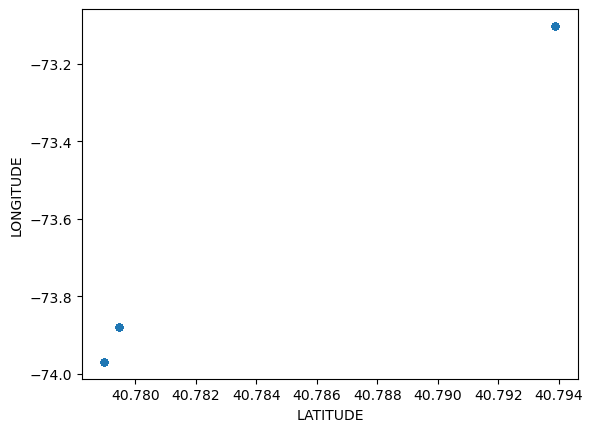

In [16]:
weather_df[['LATITUDE','LONGITUDE']].plot.scatter(x='LATITUDE',y='LONGITUDE')

### can only use two stations

In [17]:
weather_df = weather_df[weather_df['NAME'] !='ISLIP LI MACARTHUR AIRPORT, NY US']

**The five core values are:**

PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file) 

SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)

SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)

TMAX = Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file

TMIN = Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file

other value:

AWND = Average daily wind speed (meters per second or miles per hour as per user preference)

<Figure size 640x480 with 0 Axes>

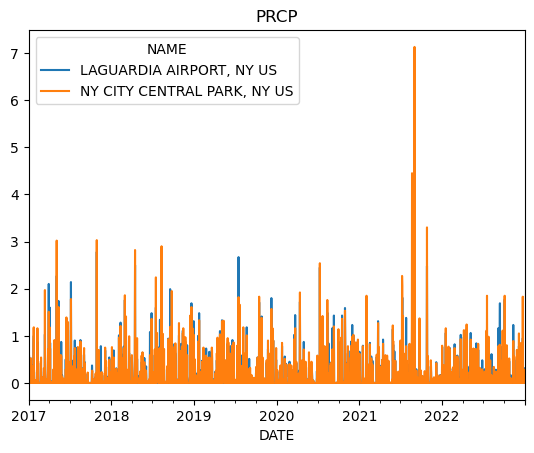

<Figure size 640x480 with 0 Axes>

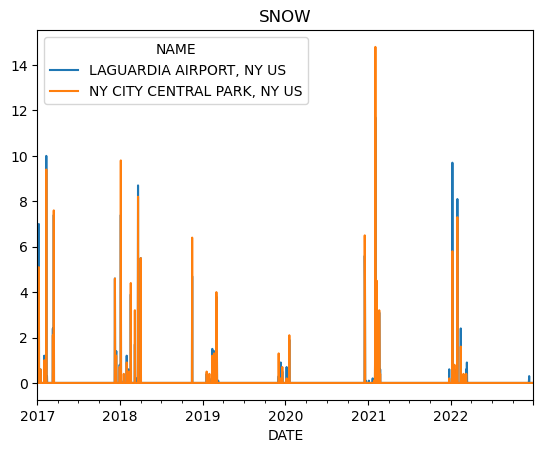

<Figure size 640x480 with 0 Axes>

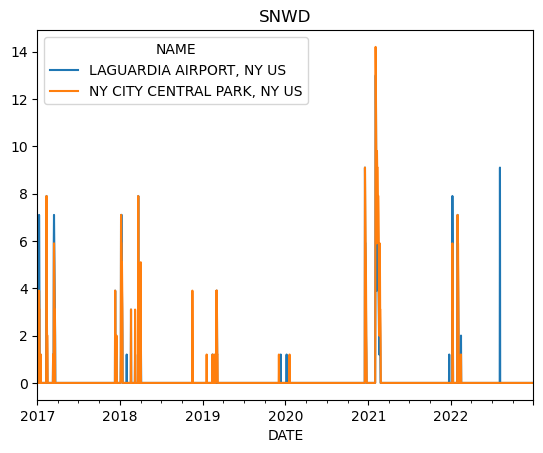

<Figure size 640x480 with 0 Axes>

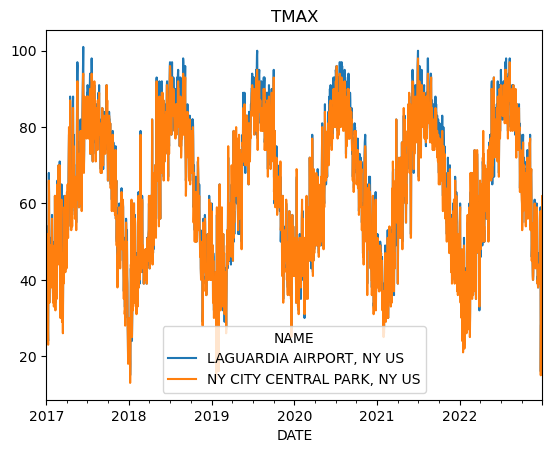

<Figure size 640x480 with 0 Axes>

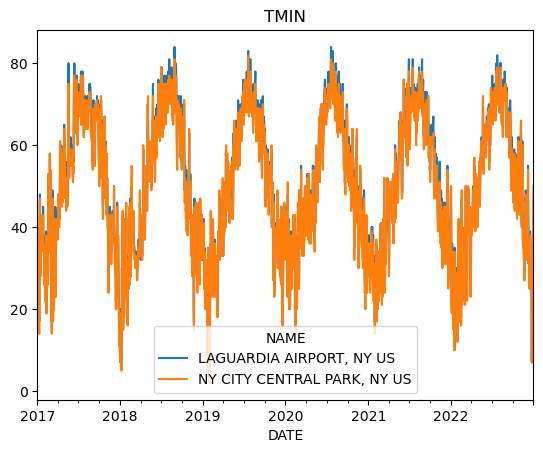

In [18]:
for col in [ 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:
    plt.figure()
    weather_df.pivot(index='DATE',columns = 'NAME',values=col).plot(title=col)

In [19]:
## Take mean of two stations and take daily pct_change

In [20]:
list_key_weather_df = []
for col in [ 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:    
    print(col, 
    weather_df.pivot(index='DATE',columns = 'NAME',values=col).sort_index().pct_change().corr().iloc[0,-1])
    tmp = weather_df.pivot(index='DATE',columns = 'NAME',values=col).mean(axis=1).to_frame().rename(columns={0:col})
    list_key_weather_df.append(tmp)
key_weather_df = pd.concat(list_key_weather_df,axis=1)

PRCP 0.6199387585394663
SNOW 0.9889583646344591
SNWD 0.950464491083613
TMAX 0.977034717467303
TMIN 0.9736494598669243


01 = Fog, ice fog, or freezing fog (may include heavy fog) 
02 = Heavy fog or heaving freezing fog (not always
distinguished from fog) 
03 = Thunder
04 = Ice pellets, sleet, snow pellets, or small hail
05 = Hail (may include small hail)
06 = Glaze or rime
08 = Smoke or haze

**there is only one day when wto9 and snow doesn't match**

In [21]:
tmp = weather_df[['WT09','SNOW']].fillna(0).sum(axis=1)
tmp[tmp==1]

1491    1.0
dtype: float64

### one day can have multiple weather types

In [22]:
weather_df.filter(like='WT').fillna(0).sum(axis=1)

1461    1.0
1462    2.0
1463    1.0
1464    2.0
1465    0.0
       ... 
7299    0.0
7300    0.0
7301    0.0
7302    0.0
7303    3.0
Length: 4382, dtype: float64

### Process WT* features
1. merge WT01 and WT02
2. create WT* as unpleasant weather days

In [26]:
weather_df['WT01'] = weather_df['WT01'].fillna(weather_df['WT02'])
weather_df['WT*'] = weather_df['WT03'].fillna(weather_df['WT04']).fillna(weather_df['WT05']).fillna(weather_df['WT06']).fillna(weather_df['WT08'])

In [27]:
list_wt_weather_df = []
for col in ['WT01', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08','WT*']:
    tmp = weather_df.pivot(index='DATE',columns = 'NAME',values=col).fillna(0).mean(axis=1).to_frame().rename(columns={0:col})
    list_wt_weather_df.append(tmp)
wt_weather_df = pd.concat(list_wt_weather_df,axis=1)

## Process AWND

In [28]:
tmp = weather_df.pivot(index='DATE',columns = 'NAME',values='AWND').fillna(0)#.mean(axis=1).to_frame().rename(columns={0:'AWND'})
tmp.pct_change().corr()

NAME,"LAGUARDIA AIRPORT, NY US","NY CITY CENTRAL PARK, NY US"
NAME,,
"LAGUARDIA AIRPORT, NY US",1.000000,0.778188
"NY CITY CENTRAL PARK, NY US",0.778188,1.000000


In [29]:
import holidays
us_holidays = holidays.US()
ny_holidays = holidays.US(state='NY')
weather_df['holiday'] = weather_df['DATE'].apply(lambda x: x in us_holidays or x in ny_holidays)

In [32]:
weather_df_model = key_weather_df.join(wt_weather_df[['WT01','WT*']]).join(
tmp['LAGUARDIA AIRPORT, NY US'].to_frame().rename(columns={'LAGUARDIA AIRPORT, NY US':'AWND'})
)
model_df = weather_df_model.join(collision_df_filtered.groupby('CRASH DATE').count()['CRASH TIME'].to_frame().rename(
    columns={'CRASH TIME':'FREQ'})).join(collision_df_filtered.groupby('CRASH DATE').sum()['ECO_COST'].to_frame()).join(
    weather_df.set_index('DATE')[['holiday']].replace({True:1, False:0})).drop_duplicates()
model_df.isnull().sum()

/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_31298/2326292027.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  columns={'CRASH TIME':'FREQ'})).join(collision_df_filtered.groupby('CRASH DATE').sum()['ECO_COST'].to_frame()).join(


PRCP        0
SNOW        0
SNWD        0
TMAX        0
TMIN        0
WT01        0
WT*         0
AWND        0
FREQ        0
ECO_COST    0
holiday     0
dtype: int64

## Model

In [33]:
weather_df_model = key_weather_df.join(wt_weather_df[['WT01','WT*']]).join(
tmp['LAGUARDIA AIRPORT, NY US'].to_frame().rename(columns={'LAGUARDIA AIRPORT, NY US':'AWND'})
)

model_df = weather_df_model.join(collision_df_filtered.groupby('CRASH DATE').count()['CRASH TIME'].to_frame().rename(
    columns={'CRASH TIME':'FREQ'})).join(collision_df_filtered.groupby('CRASH DATE').sum()['ECO_COST'].to_frame()).join(
    weather_df.set_index('DATE')[['holiday']].replace({True:1, False:0})).drop_duplicates()
                     
model_df['month'] = list(map(lambda x:x.month, model_df.index))

print(len(pd.date_range('2017-01-01','2022-12-31'))==model_df.shape[0])

model_df['TDIFF'] = model_df['TMAX'] - model_df['TMIN']
model_df[['PRCP','TMAX', 'TMIN', 'AWND','SNOW',"TDIFF"]] = model_df[['PRCP','TMAX', 'TMIN', 'AWND','SNOW','TDIFF']].diff()
X = model_df[['SNOW','TMAX']].iloc[1:,:]  #'SNWD','WT01', 'WT*''TMIN', 'AWND'
y = model_df['FREQ'].pct_change().iloc[1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

True


/var/folders/wy/vtgfkqvd5v9_mxl14t6zf4jc0000gn/T/ipykernel_31298/3844597863.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  columns={'CRASH TIME':'FREQ'})).join(collision_df_filtered.groupby('CRASH DATE').sum()['ECO_COST'].to_frame()).join(


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   FREQ   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     59.10
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           1.01e-25
Time:                        18:08:52   Log-Likelihood:                 149.51
No. Observations:                2190   AIC:                            -293.0
Df Residuals:                    2187   BIC:                            -275.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0251      0.005      5.186      0.000       0.016       0.035
SNOW          -0.0306      0.006     -5.328      0.000      -0.042      -0.019
TMAX           0.0057      0.001      9.316      0.000       0.004       0.007
==============================================================================
Omnibus:                      364.116   Durbin-Watson:                   2.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              870.131
Skew:                           0.927   Prob(JB):                    1.13e-189
Kurtosis:                       5.470   Cond. No.                         9.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

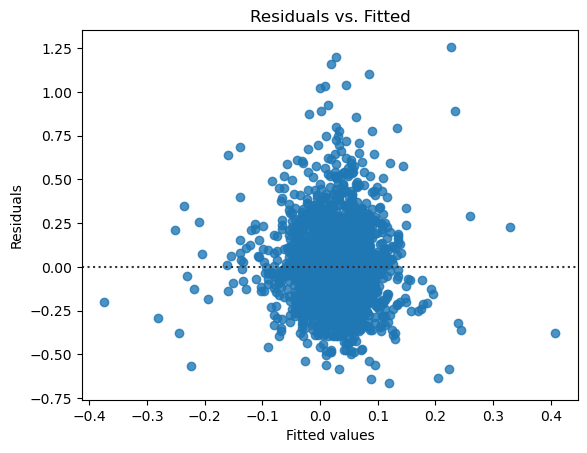

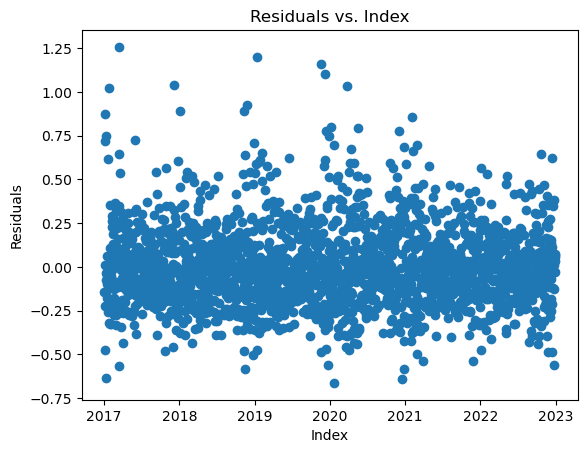

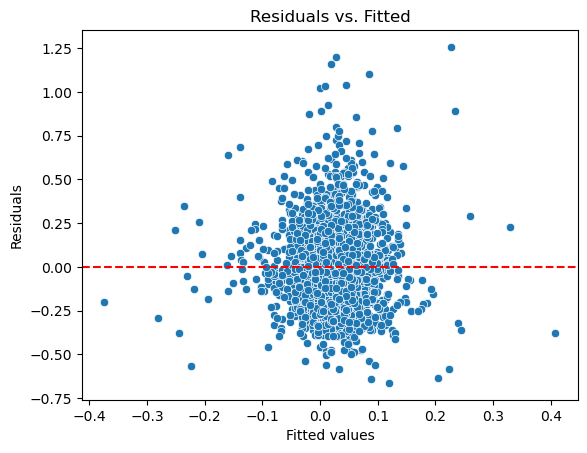

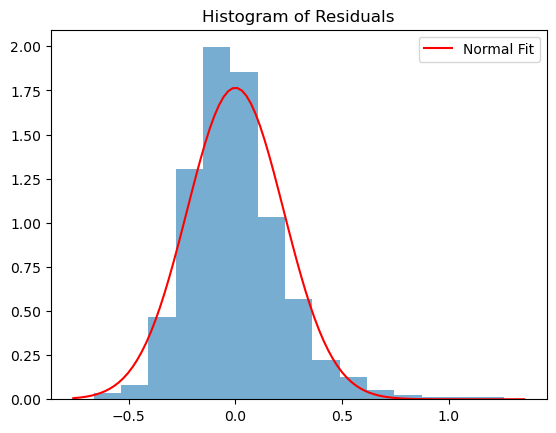

  Feature       VIF
0   const  1.000000
1    SNOW  1.000864
2    TMAX  1.000864


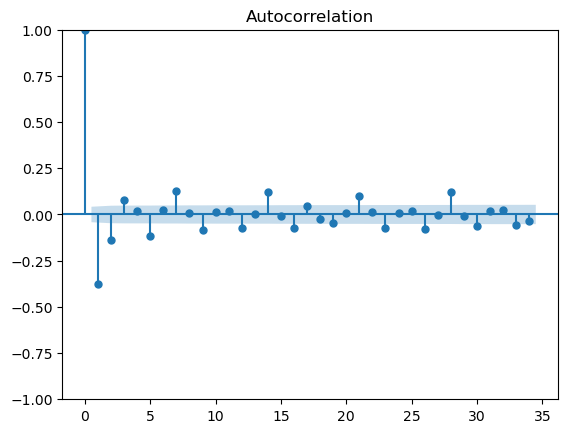

In [34]:
# Check assumptions
# 1. Linearity: Residual vs. Fitted plot
residuals = model.resid

sns.residplot(x=model.fittedvalues, y=residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

# 2. Independence of Residuals: Residual vs. Index plot
plt.scatter(model_df.iloc[1:,:].index, residuals)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals vs. Index")
plt.show()

# 3. Homoscedasticity: Residual vs. Fitted plot
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# 4. Normality of Residuals
plt.hist(residuals, bins=15, density=True, alpha=0.6)
plt.title("Histogram of Residuals")

# Overlay a normal distribution fit
x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)
normal_fit = stats.norm.pdf(x_range, np.mean(residuals), np.std(residuals))
plt.plot(x_range, normal_fit, 'r', label='Normal Fit')

plt.legend()
plt.show()

# 5. VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# 6. Autocorrelation 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals)
plt.show()


### severity

In [35]:
import statsmodels.api as sm
X = model_df[['TMAX','SNOW']].iloc[1:,:]  #SNWD 'WT01', 'WT*' 'AWND' 'PRCP'
y = model_df['ECO_COST'].pct_change().iloc[1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ECO_COST   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     47.87
Date:                Sat, 12 Aug 2023   Prob (F-statistic):           4.48e-21
Time:                        18:08:59   Log-Likelihood:                -12.873
No. Observations:                2190   AIC:                             31.75
Df Residuals:                    2187   BIC:                             48.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      0.005      5.496      0.000       0.018       0.039
TMAX           0.0054      0.001      8.186      0.000       0.004       0.007
SNOW          -0.0317      0.006     -5.118      0.000      -0.044      -0.020
==============================================================================
Omnibus:                      341.858   Durbin-Watson:                   2.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              757.114
Skew:                           0.901   Prob(JB):                    3.93e-165
Kurtosis:                       5.247   Cond. No.                         9.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

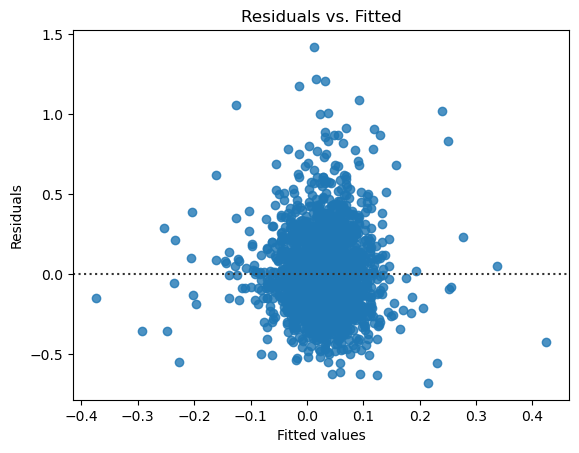

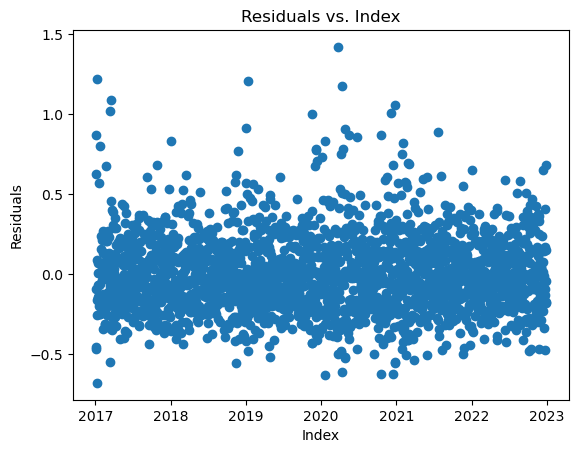

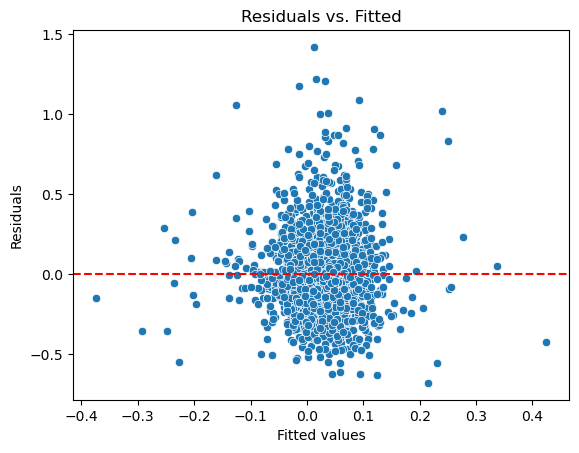

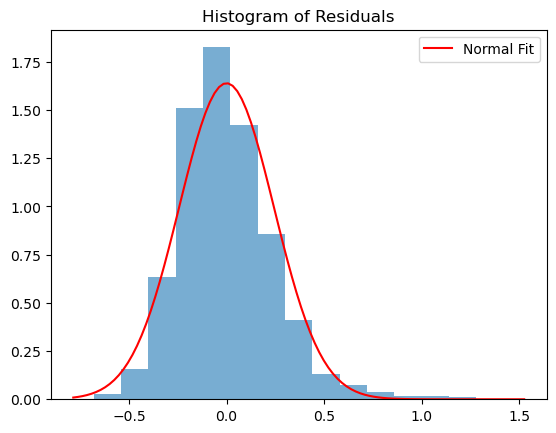

  Feature       VIF
0   const  1.000000
1    TMAX  1.000864
2    SNOW  1.000864


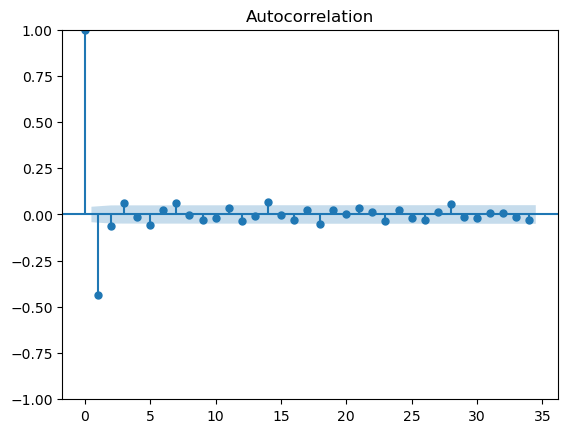

In [36]:
# Check assumptions
# 1. Linearity: Residual vs. Fitted plot
residuals = model.resid

sns.residplot(x=model.fittedvalues, y=residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

# 2. Independence of Residuals: Residual vs. Index plot
plt.scatter(model_df.iloc[1:,:].index, residuals)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals vs. Index")
plt.show()

# 3. Homoscedasticity: Residual vs. Fitted plot
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# 4. Normality of Residuals
plt.hist(residuals, bins=15, density=True, alpha=0.6)
plt.title("Histogram of Residuals")

# Overlay a normal distribution fit
x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)
normal_fit = stats.norm.pdf(x_range, np.mean(residuals), np.std(residuals))
plt.plot(x_range, normal_fit, 'r', label='Normal Fit')

plt.legend()
plt.show()


# 5. VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# 6. Autocorrelation (if applicable)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals)
plt.show()